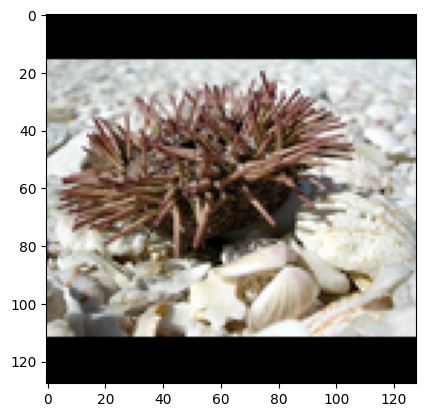

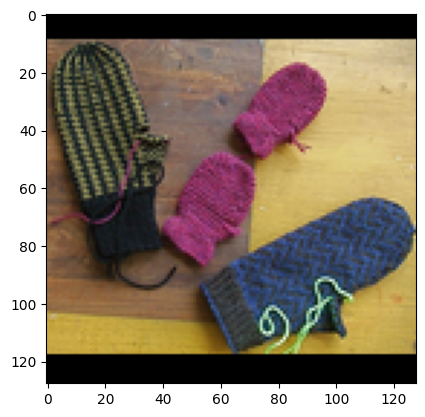

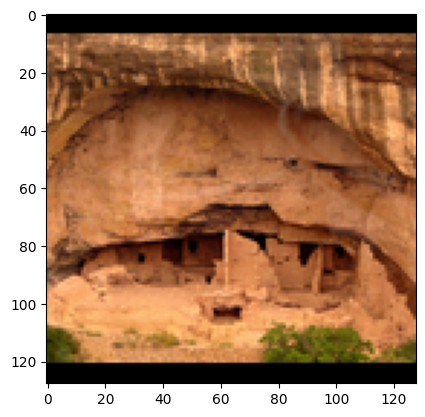

In [2]:
from decouple import Config, RepositoryEnv
import sys
sys.path.insert(0, "..")
from dataset import ImagenetDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

config = Config(RepositoryEnv("../../.env"))
dataloader = DataLoader(ImagenetDataset(), batch_size=1, shuffle=True)
cnt = 0
for img, label in dataloader:
    img = img.squeeze(0)
    fig = plt.figure()
    plt.imshow(img)
    cnt += 1
    if cnt > 2:
        break